In [1]:
! pip install --upgrade ultralytics 
!pip install --upgrade -U ray[tune]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.0/869.0 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 24.3 MB/s eta 0:00:00
  Attempting uninstall: ray
    Found existing installation: ray 2.9.0
    Uninstalling ray-2.9.0:
      Successfully uninstalled ray-2.9.0


**Important!** <br>
1. Add this datasource for notebok to work correctly!<br>
https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow
2. Select accelerator "GPU P100"
3. Leave "Internet on"



[CSS (Construction Site Safety) Dataset](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow):

- Labels in this dataset:
    - 0: Hardhat
    - 1: Mask
    - 2: NO-Hardhat
    - 3: NO-Mask
    - 4: NO-Safety Vest
    - 5: Person
    - 6: Safety Cone
    - 7: Safety Vest
    - 8: Machinery
    - 9: Vehicle


- Label Annotation: YOLO format (.txt)
     - `[class_id, center_x, center_y, width, height]`
      
___      

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

%matplotlib inline

! wandb disabled

W&B disabled.


In [3]:
class CFG:
    DEBUG = False # Set to True to make quick experiments
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 42

    # classes
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 70 # 100
    BATCH_SIZE = 8
    
    BASE_MODEL = 'yolov9e' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/css-data/'
    OUTPUT_DIR = '/kaggle/working/'

Create ```data.yaml``` file properly formatted to be used by Yolo

In [4]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [5]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: /kaggle/input/css-data/test
train: /kaggle/input/css-data/train
val: /kaggle/input/css-data/valid



Visualize one image

In [6]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



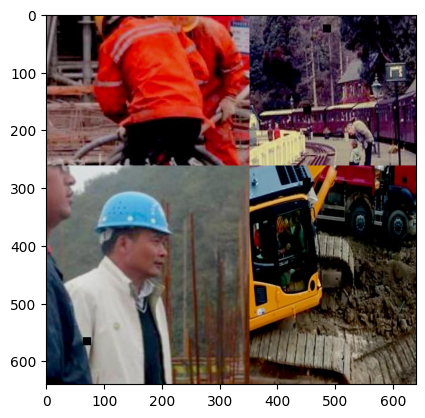

In [7]:
example_image_path = CFG.CUSTOM_DATASET_DIR + 'train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

Visualize many images

In [8]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

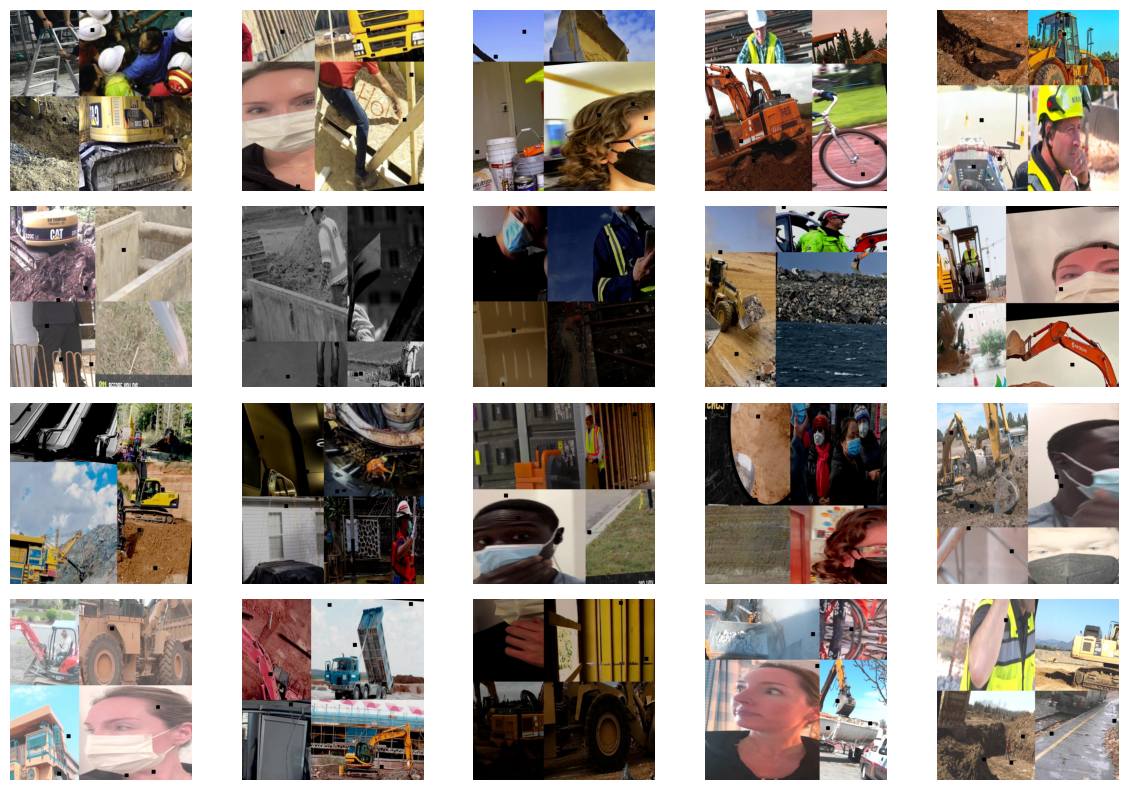

In [9]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

Image properties

In [10]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [11]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

Dataset statistics

In [12]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None): 
    display(dataset_stats_df)


,Mode,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle,Data_Volume
0,train,1314,1096,1380,1531,1864,2526,631,1319,2101,744,2605
1,valid,42,19,37,44,56,84,13,28,26,16,114
2,test,30,16,25,30,36,59,8,22,22,15,82


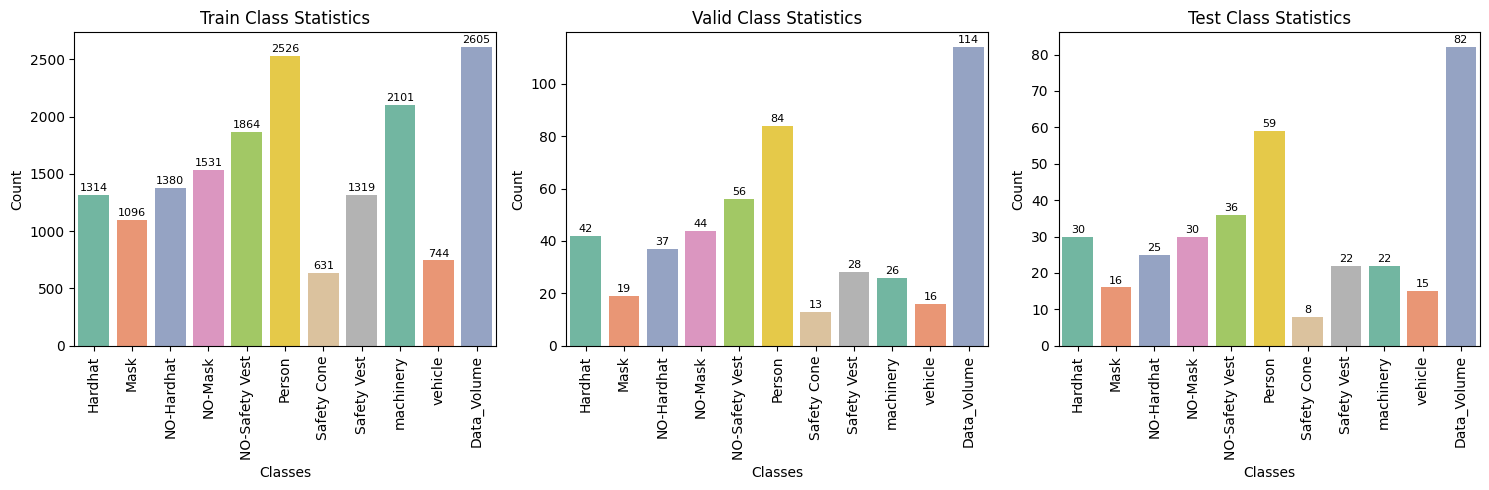

In [13]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

Base Model Inference

Checking the power of the pretrained model inference on the CSS dataset

In [14]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.30,
#     device = [0,1], # inference with dual GPU
    device = None, # inference with CPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

100%|██████████| 112M/112M [00:00<00:00, 288MB/s]



image 1/1 /kaggle/input/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg: 640x640 8 persons, 48.0ms
Speed: 9.2ms preprocess, 48.0ms inference, 257.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



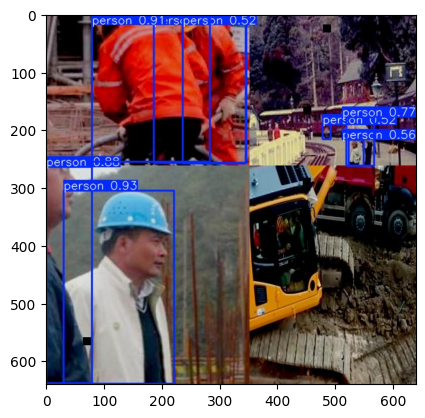

In [15]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')

Train

[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [16]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9e.pt
Epochs:  70
Batch:  8


In [17]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

**IMPORTANT**<br>
Modify `/home/user/.config/Ultralytics/settings.yaml` file so that there is no errors loading the data


In [18]:
%%time

### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,
    
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    device = [0], 
#     device = None, # CPU run
    verbose = False,
)

Ultralytics YOLOv8.2.77 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=/kaggle/working/data.yaml, epochs=70, time=None, patience=20, batch=8, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=yolov9e_ppe_css_70_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

100%|██████████| 755k/755k [00:00<00:00, 22.0MB/s]
2024-08-15 12:13:50,540	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-08-15 12:13:50,766	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


WARNING ⚠️ YOLOv9 `Silence` module is deprecated in favor of nn.Identity. Please delete local *.pt file and re-download the latest model checkpoint.
Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1         0  torch.nn.modules.linear.Identity             []                            
  1                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  2                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  3                  -1  1    252160  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 2]        
  4                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  5                  -1  1   1004032  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 2]       
  6          

100%|██████████| 6.25M/6.25M [00:00<00:00, 112MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/input/css-data/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:04<00:00, 529.51it/s]

train: WARNING ⚠️ /kaggle/input/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/css-data/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/css-data/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 423.74it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/css-data/valid is not writeable, cache not saved.


Plotting labels to runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov9e_ppe_css_70_epochs
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70        12G      1.279      1.784      1.516        147        640: 100%|██████████| 326/326 [05:52<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        114        697      0.469      0.435       0.43      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      11.1G      1.305      1.663      1.539         93        640: 100%|██████████| 326/326 [05:38<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]

                   all        114        697       0.56       0.44      0.447      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70        11G       1.29      1.641      1.532         85        640: 100%|██████████| 326/326 [05:35<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

                   all        114        697      0.515      0.483      0.473      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      11.6G      1.252      1.573      1.506         91        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        114        697      0.615      0.517      0.534      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      11.1G      1.219      1.474      1.473        113        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        114        697      0.728      0.516       0.58      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      11.1G      1.184      1.381      1.439         64        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        114        697      0.696      0.563      0.598       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      11.1G      1.148      1.295      1.411        113        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        114        697      0.727      0.562      0.615      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      11.6G      1.123      1.247      1.399         87        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        114        697      0.793      0.584      0.641       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      11.1G      1.107      1.201      1.378        108        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        114        697      0.785       0.59      0.655      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      11.1G      1.076      1.128      1.358        110        640: 100%|██████████| 326/326 [05:35<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        114        697      0.859      0.594      0.689      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      11.1G      1.061        1.1      1.345         64        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.797      0.636      0.693       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      11.2G      1.042      1.056      1.334        257        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.803      0.632      0.682      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      11.1G      1.033      1.044      1.331        132        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.823      0.629      0.719      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      11.1G      1.016      1.008      1.313         94        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.806      0.652      0.703      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      11.1G     0.9974     0.9715      1.296         74        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.805      0.661      0.723      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      11.6G     0.9868     0.9419      1.294        119        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.846      0.639       0.73      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      11.1G      0.968     0.9203      1.283         58        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.837      0.636      0.717      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      11.1G     0.9573      0.891      1.272         79        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.863      0.675      0.747      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      11.1G     0.9436     0.8663      1.254        135        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        114        697      0.836      0.672      0.736      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      11.6G     0.9326     0.8426       1.25        149        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.828      0.676      0.752      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      11.1G     0.9176     0.8239      1.239        152        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.851      0.684      0.757      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      11.1G     0.9026     0.7959      1.232         80        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        114        697      0.837      0.714      0.766      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      11.8G     0.8937     0.7887      1.224         73        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.874       0.71      0.796      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      11.6G     0.8873     0.7792      1.218        110        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.891      0.711      0.792      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      11.1G     0.8785     0.7594      1.213        114        640: 100%|██████████| 326/326 [05:35<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.888       0.71      0.777      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      11.1G     0.8728     0.7398      1.205        103        640: 100%|██████████| 326/326 [05:35<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.871      0.708      0.778      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      11.8G     0.8564     0.7195      1.195        100        640: 100%|██████████| 326/326 [05:35<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.895      0.719      0.798      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      11.6G     0.8439     0.7102      1.187         95        640: 100%|██████████| 326/326 [05:35<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.871      0.748       0.81      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      11.1G     0.8412     0.6975       1.18         89        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.897      0.711      0.797      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      11.1G     0.8214     0.6854      1.169        199        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.855      0.742      0.804      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      11.1G       0.81     0.6666      1.162         77        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.868      0.742      0.817      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70        11G     0.8043     0.6559       1.16        166        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.876      0.735      0.811        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      11.1G     0.8014     0.6509      1.149         94        640: 100%|██████████| 326/326 [05:35<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697       0.85      0.738      0.814      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      11.1G      0.781     0.6303      1.145        113        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.908      0.725      0.817      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      11.1G     0.7858     0.6285      1.144        101        640: 100%|██████████| 326/326 [05:35<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.884       0.73      0.809      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70        11G     0.7725     0.6198      1.132         72        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.868       0.76      0.811      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      11.1G     0.7663     0.6131      1.133        118        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        114        697       0.86      0.768      0.825      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      11.1G     0.7561     0.6021      1.128         55        640: 100%|██████████| 326/326 [05:35<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.922      0.748      0.824      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      11.1G     0.7404      0.581      1.113        197        640: 100%|██████████| 326/326 [05:35<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.931      0.736      0.831      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      11.6G     0.7434     0.5756      1.108        109        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.928      0.759      0.848      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      11.1G     0.7259     0.5692      1.098         67        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.911      0.747      0.836      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      11.1G     0.7318     0.5626      1.105         90        640: 100%|██████████| 326/326 [05:35<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.919       0.78      0.839       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      11.1G     0.7213     0.5589      1.092        139        640: 100%|██████████| 326/326 [05:35<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.887      0.791      0.846      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      11.6G     0.6983     0.5411      1.091        113        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.925      0.776      0.855      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      11.1G     0.6956     0.5392      1.092         95        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.915      0.787      0.854      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      11.1G     0.6933     0.5254      1.086        116        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.925      0.807      0.862      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      11.1G      0.684     0.5172      1.083        214        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.901      0.769      0.851      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      11.6G     0.6832     0.5123      1.077        126        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.939       0.76      0.855      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      11.8G     0.6695     0.5021      1.067         99        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697       0.93       0.78      0.855      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      11.1G     0.6602     0.4882      1.061        159        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.917      0.792      0.863      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      11.1G     0.6591      0.498      1.063        188        640: 100%|██████████| 326/326 [05:35<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.911      0.809      0.867      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70        11G     0.6473      0.479      1.056         49        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.928      0.808      0.868      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      11.1G      0.645     0.4752      1.049         74        640: 100%|██████████| 326/326 [05:35<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.912      0.815       0.87      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      11.1G     0.6384     0.4722      1.044         85        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.923      0.799      0.866      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      11.1G     0.6273     0.4615       1.04        137        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697        0.9      0.812      0.868      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      11.6G     0.6232     0.4596      1.034         51        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.954      0.801      0.869      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      11.1G     0.6089      0.454      1.031         49        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.925      0.804       0.87      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      11.1G     0.6031     0.4444      1.023         91        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.939      0.797      0.866      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      11.1G     0.5961     0.4381      1.023         97        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.941      0.784      0.864      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      11.6G     0.5939     0.4347      1.027        113        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.947      0.793      0.865      0.613


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      11.1G     0.5841      0.368       1.01         50        640: 100%|██████████| 326/326 [05:36<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.928      0.798       0.87      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      11.1G     0.5714     0.3537      1.002         42        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.932      0.801      0.872      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      11.1G     0.5609     0.3473     0.9983         68        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.942        0.8       0.87      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70        11G     0.5531     0.3427     0.9907         45        640: 100%|██████████| 326/326 [05:33<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.929      0.812      0.876      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      11.1G      0.541     0.3335     0.9788         47        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.935      0.805      0.879      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      11.1G     0.5372     0.3301     0.9767         36        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.943       0.81      0.883      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      11.1G     0.5318     0.3269     0.9725         45        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.909      0.832      0.882      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      11.6G     0.5233       0.32     0.9671         31        640: 100%|██████████| 326/326 [05:34<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697       0.95      0.801      0.874      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      11.1G     0.5112      0.313      0.961         58        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        114        697      0.942      0.807      0.878      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      11.1G     0.5074     0.3149     0.9632         61        640: 100%|██████████| 326/326 [05:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        114        697      0.931      0.804      0.874      0.642



70 epochs completed in 6.697 hours.
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/last.pt, 117.3MB
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt, 117.3MB

Validating runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt...
Ultralytics YOLOv8.2.77 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


                   all        114        697      0.933      0.804      0.874      0.642
Speed: 0.2ms preprocess, 65.5ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/yolov9e_ppe_css_70_epochs
CPU times: user 5h 7min 16s, sys: 1h 38min 4s, total: 6h 45min 20s
Wall time: 6h 42min 42s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aa7c0389240>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

[Export mode](https://docs.ultralytics.com/modes/export/) is used for exporting a YOLOv9 model to a format that can be used for deployment. In this mode, the model is converted to a format that can be used by other software applications or hardware devices. This mode is useful when deploying the model to production environments.

In [19]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.2.77 🚀 Python-3.10.13 torch-2.1.2 CPU (Intel Xeon 2.00GHz)
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (111.9 MB)

ONNX: starting export with onnx 1.16.1 opset 17...
ONNX: export success ✅ 10.2s, saved as 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx' (219.3 MB)

Export complete (17.3s)
Results saved to /kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx imgsz=640 data=/kaggle/working/data.yaml  
Visualize:       https://netron.app


'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx'

Train results

In [20]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/results.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg']

/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png


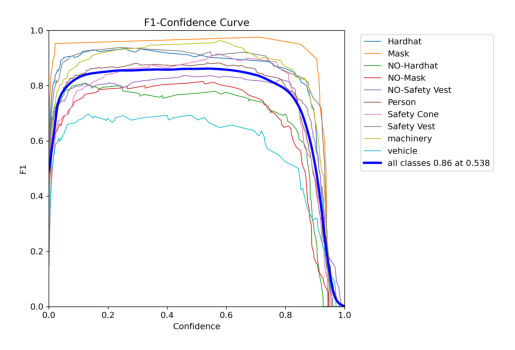



/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png


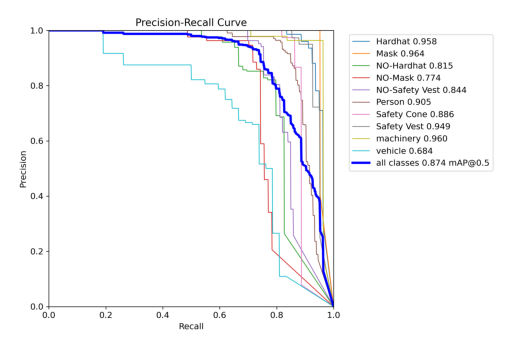



/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png


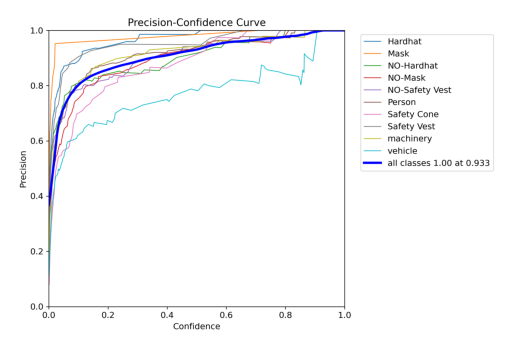



/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png


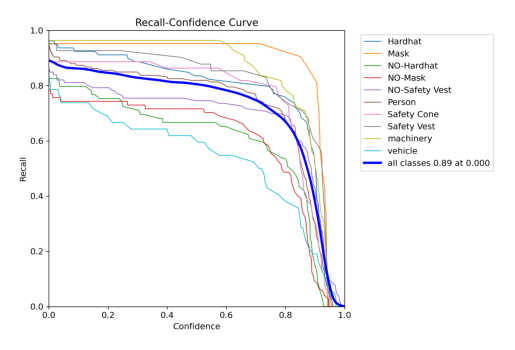



/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png


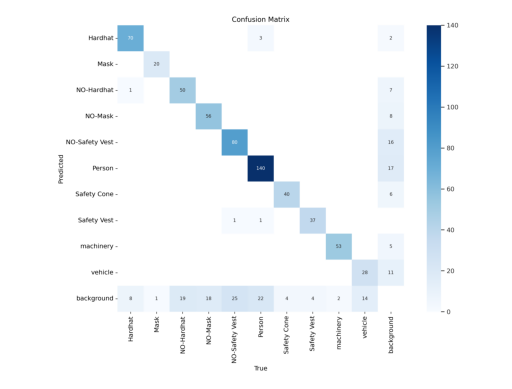



/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png


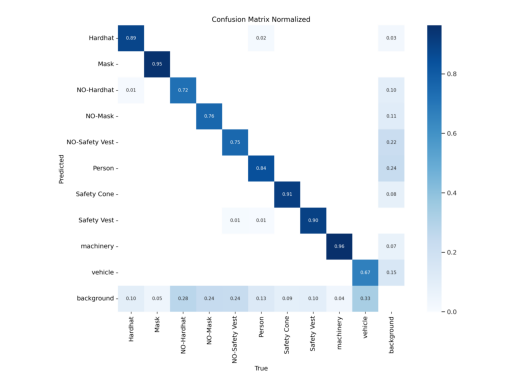



/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg


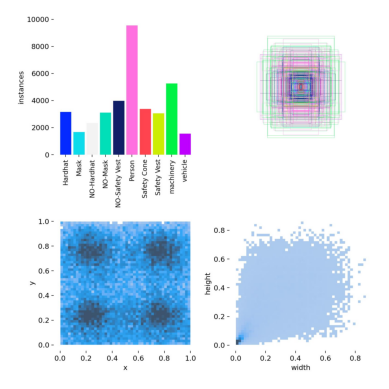



/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg


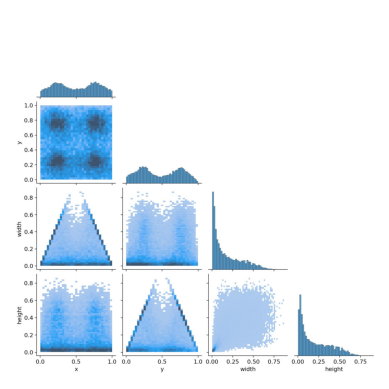



/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/results.png


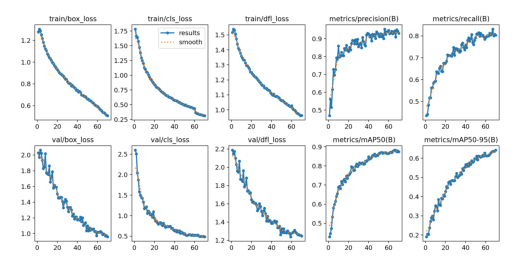

In [21]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

Loss

- The loss function in YOLO consists of three main components: box loss, class loss (cls loss), and objectness loss (dfl loss).
- The total loss in YOLO is a combination of these three components

___

**Box loss:**
- The box loss measures how accurately the predicted bounding box coordinates match the ground truth bounding box.
- Is typically computed using a regression loss, such as Mean Squared Error (MSE), between the predicted bounding box coordinates (center coordinates, width, and height) and the ground truth bounding box coordinates.

___

**Class loss (cls):**
- The class loss measures how well the predicted class probabilities match the true class labels.
- The class loss is usually computed using a categorical cross-entropy loss, which penalizes the difference between the predicted class probabilities and the true class labels.

___

**Objectness loss (dfl):**
- Distribution Focal Loss
- YOLO predicts an "objectness" score for each bounding box, indicating the presence of an object within the grid cell. This score helps filter out irrelevant bounding boxes.
- The objectness loss is calculated based on the difference between the predicted objectness score and the ground truth objectness label. It penalizes the model for false positives and false negatives in predicting the presence of an object.

In [22]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.27850,1.78450,1.51600,0.46865,0.43500,0.42978,0.19079,2.02860,2.59950,2.1877,0.000237,0.000237,0.000237
1,2,1.30490,1.66280,1.53940,0.56045,0.44049,0.44656,0.20428,1.97000,2.50870,2.1475,0.000469,0.000469,0.000469
2,3,1.28970,1.64130,1.53170,0.51527,0.48333,0.47314,0.20373,2.06310,2.03860,2.1726,0.000693,0.000693,0.000693
3,4,1.25230,1.57340,1.50600,0.61548,0.51683,0.53365,0.23674,2.02310,1.87100,2.0994,0.000684,0.000684,0.000684
4,5,1.21860,1.47400,1.47350,0.72769,0.51640,0.58009,0.27063,1.93330,1.58060,2.0302,0.000674,0.000674,0.000674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,0.53723,0.33009,0.97671,0.94346,0.81006,0.88260,0.63226,0.99612,0.49411,1.2631,0.000058,0.000058,0.000058
66,67,0.53180,0.32686,0.97247,0.90916,0.83168,0.88178,0.63622,0.98805,0.49403,1.2643,0.000048,0.000048,0.000048
67,68,0.52327,0.32004,0.96708,0.95040,0.80113,0.87436,0.63653,0.96891,0.49552,1.2568,0.000037,0.000037,0.000037
68,69,0.51123,0.31302,0.96099,0.94183,0.80720,0.87839,0.63710,0.97510,0.49286,1.2575,0.000027,0.000027,0.000027


In [23]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.50745 , on epoch:  70 


Best Validation Box loss:  0.95959 , on epoch:  70 


Best Training Cls loss:  0.31302 , on epoch:  69 


Best Validation Cls loss:  0.48584 , on epoch:  70 


Best Training DFL loss:  0.96099 , on epoch:  69 


Best Validation DFL loss:  1.239 , on epoch:  59 



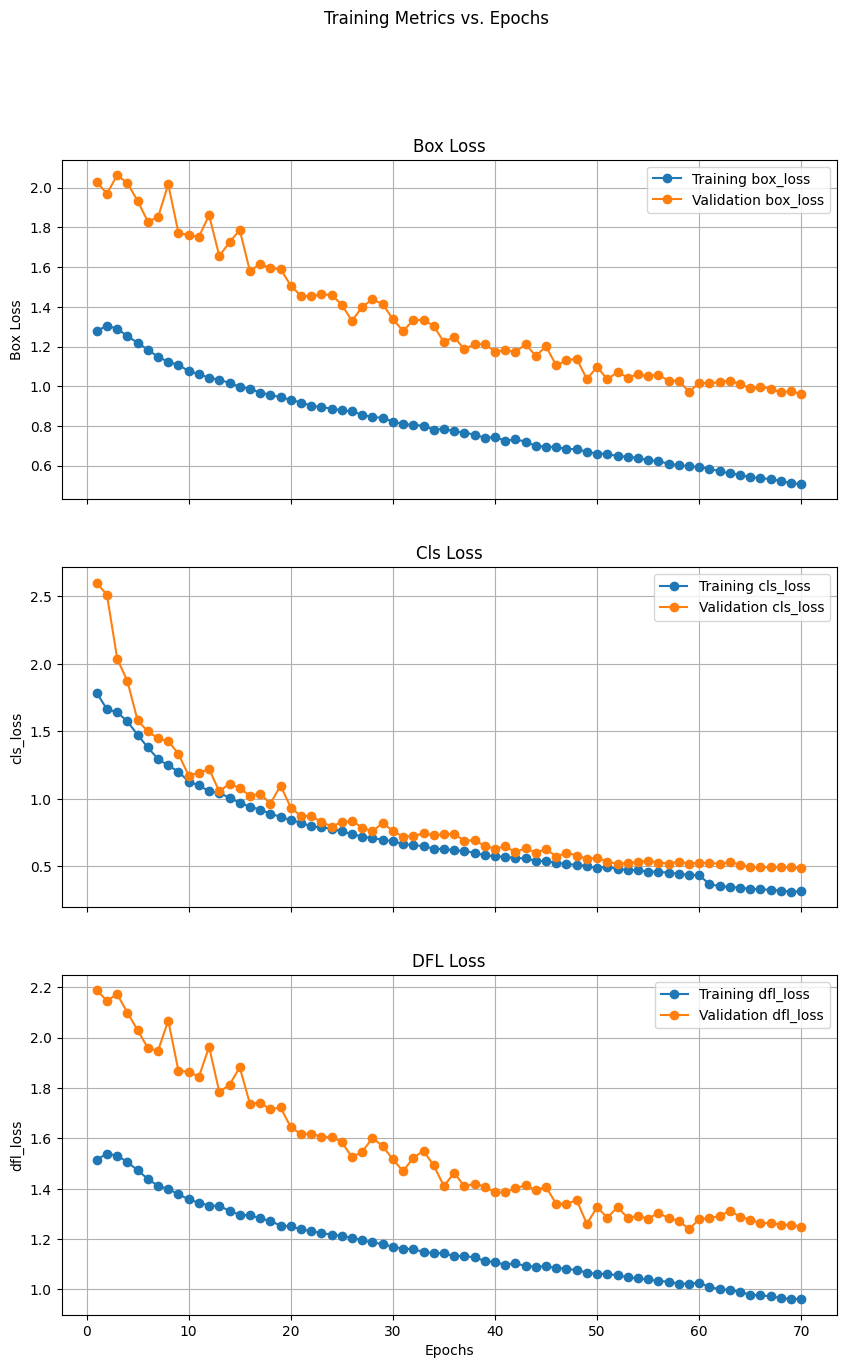

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

Validation results

In [25]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [26]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/val_batch0_labels.jpg


/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/val_batch1_pred.jpg


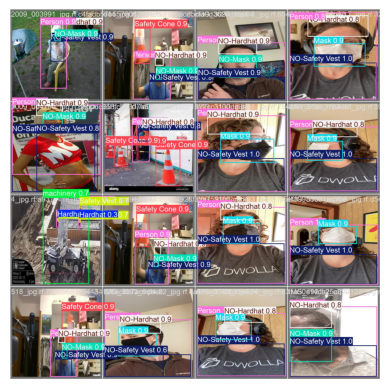

In [27]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)